In [1]:
# ============================
# 1. Imports
# ============================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm

# ============================
# 2. Device Setup
# ============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [2]:
# ============================
# 3. Dataset & Dataloaders
# ============================

data_dir = "/kaggle/input/cucumber-disease-8-classes/Original Image"  # <-- change this to your dataset path

# Transforms (resize to 224x224, normalize for DenseNet)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

# Load dataset
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
class_names = dataset.classes
num_classes = len(class_names)
print("Classes:", class_names)

# Split into train(70%), val(15%), test(15%)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Classes: ['Anthracnose', 'Bacterial Wilt', 'Belly Rot', 'Downy Mildew', 'Fresh Cucumber', 'Fresh Leaf', 'Gummy Stem Blight', 'Pythium Fruit Rot']


In [3]:
# ============================
# 3. Dataset & Dataloaders (with Augmentation)
# ============================

import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split

data_dir = "/kaggle/input/cucumber-disease-8-classes/Original Image"  # <-- change this to your dataset path

# 🔹 Training data augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),     # Flip horizontally
    transforms.RandomRotation(20),              # Rotate ±20 degrees
    transforms.ColorJitter(brightness=0.2, 
                           contrast=0.2, 
                           saturation=0.2, 
                           hue=0.1),            # Random color variations
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Random zoom/crop
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

# 🔹 Validation & Test transforms (no augmentation)
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

# Load dataset (without transform at first)
full_dataset = datasets.ImageFolder(root=data_dir, transform=None)
class_names = full_dataset.classes
num_classes = len(class_names)
print("Classes:", class_names)

# Split dataset
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size]
)

# Apply transforms separately
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_test_transform
test_dataset.dataset.transform = val_test_transform

# DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Classes: ['Anthracnose', 'Bacterial Wilt', 'Belly Rot', 'Downy Mildew', 'Fresh Cucumber', 'Fresh Leaf', 'Gummy Stem Blight', 'Pythium Fruit Rot']


In [4]:
# ============================
# 1. Model (DenseNet-169)
# ============================
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

# Load pretrained DenseNet-169
model = models.densenet169(weights="IMAGENET1K_V1")

# Replace classifier with number of classes
num_classes = len(class_names)   # <-- make sure class_names is defined from dataset
in_features = model.classifier.in_features
model.classifier = nn.Linear(in_features, num_classes)

model = model.to(device)

# ============================
# 2. Loss, Optimizer, Epochs
# ============================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
epochs = 15


Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth
100%|██████████| 54.7M/54.7M [00:00<00:00, 184MB/s]


In [5]:
from tqdm import tqdm

def train_model(model, criterion, optimizer, train_loader, val_loader, epochs, device, aux_logits=False):
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")

        # -----------------------------
        # Training phase
        # -----------------------------
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        loop = tqdm(train_loader, leave=False)

        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            if aux_logits and isinstance(outputs, tuple):
                # InceptionV3 (main + auxiliary output)
                main_outputs, aux_outputs = outputs
                loss1 = criterion(main_outputs, labels)
                loss2 = criterion(aux_outputs, labels)
                loss = loss1 + 0.4 * loss2   # weighted sum
                preds = torch.max(main_outputs, 1)[1]
            else:
                # Normal models
                loss = criterion(outputs, labels)
                preds = torch.max(outputs, 1)[1]

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            loop.set_description(f"Train Epoch [{epoch+1}/{epochs}]")
            loop.set_postfix(loss=loss.item())

        train_loss = running_loss / total
        train_acc = correct / total

        # -----------------------------
        # Validation phase
        # -----------------------------
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                if aux_logits and isinstance(outputs, tuple):
                    outputs = outputs[0]  # only use main output for validation

                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                preds = torch.max(outputs, 1)[1]
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss /= val_total
        val_acc = val_correct / val_total

        # Save history
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return history
history = train_model(model, criterion, optimizer, train_loader, val_loader, epochs, device)


Epoch 1/15


Epoch 1/15 - Train Loss: 0.9502, Train Acc: 0.7195, Val Loss: 0.3885, Val Acc: 0.9016

Epoch 2/15


Epoch 2/15 - Train Loss: 0.1788, Train Acc: 0.9789, Val Loss: 0.2123, Val Acc: 0.9378

Epoch 3/15


Epoch 3/15 - Train Loss: 0.0746, Train Acc: 0.9911, Val Loss: 0.1989, Val Acc: 0.9430

Epoch 4/15


Epoch 4/15 - Train Loss: 0.0535, Train Acc: 0.9956, Val Loss: 0.1723, Val Acc: 0.9482

Epoch 5/15


Epoch 5/15 - Train Loss: 0.0469, Train Acc: 0.9933, Val Loss: 0.1839, Val Acc: 0.9378

Epoch 6/15


Epoch 6/15 - Train Loss: 0.0258, Train Acc: 0.9989, Val Loss: 0.2015, Val Acc: 0.9430

Epoch 7/15


Epoch 7/15 - Train Loss: 0.0189, Train Acc: 1.0000, Val Loss: 0.1574, Val Acc: 0.9585

Epoch 8/15


Epoch 8/15 - Train Loss: 0.0237, Train Acc: 0.9956, Val Loss: 0.2146, Val Acc: 0.9534

Epoch 9/15


Epoch 9/15 - Train Loss: 0.0147, Train Acc: 0.9978, Val Loss: 0.1871, Val Acc: 0.9534

Epoch 10/15


Epoch 10/15 - Train Loss: 0.0186, Train Acc: 0.9967, Val Loss: 0.2037, Val Acc: 0.9430

Epoch 11/15


Epoch 11/15 - Train Loss: 0.0159, Train Acc: 0.9956, Val Loss: 0.2120, Val Acc: 0.9326

Epoch 12/15


Epoch 12/15 - Train Loss: 0.0244, Train Acc: 0.9922, Val Loss: 0.2011, Val Acc: 0.9585

Epoch 13/15


Epoch 13/15 - Train Loss: 0.0388, Train Acc: 0.9889, Val Loss: 0.2377, Val Acc: 0.9378

Epoch 14/15


Epoch 14/15 - Train Loss: 0.0268, Train Acc: 0.9945, Val Loss: 0.2181, Val Acc: 0.9378

Epoch 15/15


Epoch 15/15 - Train Loss: 0.0114, Train Acc: 0.9989, Val Loss: 0.2095, Val Acc: 0.9585


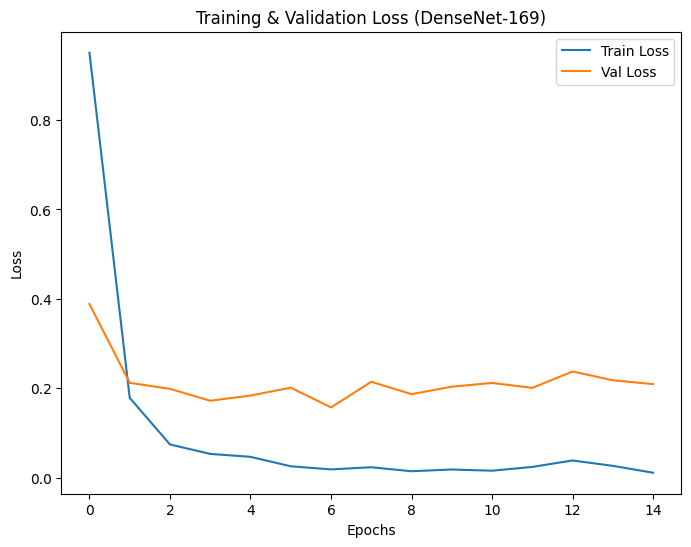

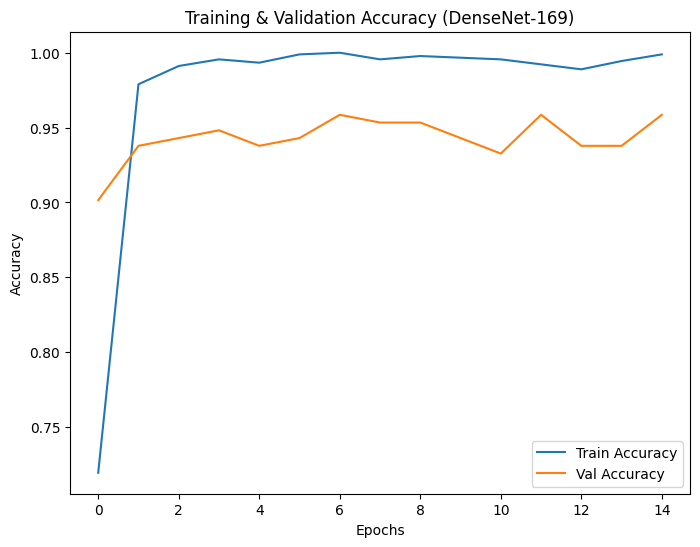

In [6]:
# ============================
# 7. Plot Training History
# ============================

# Loss Curve
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss (DenseNet-169)")
plt.legend()
plt.show()

# Accuracy Curve
plt.figure(figsize=(8,6))
plt.plot(history["train_acc"], label="Train Accuracy")
plt.plot(history["val_acc"], label="Val Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy (DenseNet-169)")
plt.legend()
plt.show()


⚠️ best_densenet169.pth not found, using last trained model

Classification Report:
                   precision    recall  f1-score   support

      Anthracnose       0.85      0.81      0.83        27
   Bacterial Wilt       0.97      1.00      0.98        28
        Belly Rot       0.96      1.00      0.98        23
     Downy Mildew       0.85      0.96      0.90        23
   Fresh Cucumber       1.00      1.00      1.00        21
       Fresh Leaf       0.82      1.00      0.90        23
Gummy Stem Blight       1.00      0.68      0.81        25
Pythium Fruit Rot       1.00      0.96      0.98        24

         accuracy                           0.92       194
        macro avg       0.93      0.93      0.92       194
     weighted avg       0.93      0.92      0.92       194



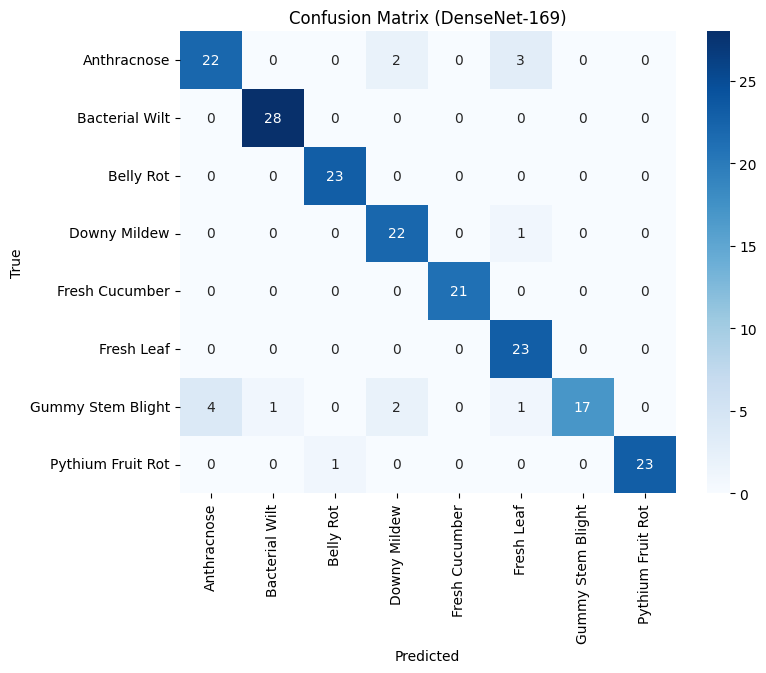

In [7]:
# ============================
# 8. Testing & Evaluation
# ============================
import os

if os.path.exists("best_densenet169.pth"):
    model.load_state_dict(torch.load("best_densenet169.pth", map_location=device))
    print("Loaded best model successfully ✅")
else:
    print("⚠️ best_densenet169.pth not found, using last trained model")

model.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification Report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix (DenseNet-169)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
